In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from datetime import datetime, date
import time
import pandas as pd
import os
import numpy as np
import json

from matplotlib import pyplot as plt
import matplotlib

from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import set_matplotlib_formats

def setup_matplotlib(use_ggplot=True):
    """
    Setup all the stylistic params of matplotlib.
    Pass the file path to the Matplotlib rcParams file.
    """

    # Set ggplot style
    if use_ggplot:
        plt.style.use('ggplot')

    # Overwrite rcParams with the custom style file
    params = json.load(open('matplotlibrc.json', 'r'))
    matplotlib.rcParams.update(params)



def set_css_style():
    """
    Read the custom CSS file and load it into Jupyter.
    Pass the file path to the CSS file.
    """

    styles = open('custom.css', 'r').read()
    return HTML(styles)


%matplotlib inline 

setup_matplotlib()
set_css_style()

/Users/martina/Desktop/Mallzee/repos/plantation/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Edinburgh Marathon 2019 - discovering the obvious?

From the results on the website, fetch all participants' demographic info and time. 

Use phanthomJS via selenium to simulate the browser because the page got JS. Spit each pagination into HTML files.

Then have a look at this data, it's good fun.

In [2]:
url = "https://www.edinburghmarathon.com/results/"

In [3]:
# initialise a headless browser and run it on the URL

driver = webdriver.PhantomJS()
driver.get(url)

/Users/martina/Desktop/Mallzee/repos/plantation/venv/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [4]:
# get the first 50 results from browser

first_results = driver.find_element_by_link_text("2019 Edinburgh Marathon")
first_results.click()

In [5]:
# and write them to file

f = open("page_1.html", 'w')
f.write(driver.page_source)
f.close()

In [6]:
# loop by clocking on the NEXT button to get all reaulst
# write each of them on file

i = 2
while 1:
    
    print(i)
    
    element_next = driver.find_element_by_link_text("NEXT")
    element_next.click()
    
    time.sleep(3)    # need to wait otherwise doesnt' load page and gives the previous one
    
    f = open("page_{i}.html".format(i=i), 'w')
    f.write(driver.page_source)
    f.close()
        
    i += 1

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


NoSuchElementException: Message: {"errorMessage":"Unable to find element with link text 'NEXT'","request":{"headers":{"Accept":"application/json","Accept-Encoding":"identity","Content-Length":"92","Content-Type":"application/json;charset=UTF-8","Host":"127.0.0.1:61684","User-Agent":"selenium/3.141.0 (python mac)"},"httpVersion":"1.1","method":"POST","post":"{\"using\": \"link text\", \"value\": \"NEXT\", \"sessionId\": \"5456cb30-845d-11e9-bb4a-17f487e3dcd6\"}","url":"/element","urlParsed":{"anchor":"","query":"","file":"element","directory":"/","path":"/element","relative":"/element","port":"","host":"","password":"","user":"","userInfo":"","authority":"","protocol":"","source":"/element","queryKey":{},"chunks":["element"]},"urlOriginal":"/session/5456cb30-845d-11e9-bb4a-17f487e3dcd6/element"}}
Screenshot: available via screen


## Parse the HTMLs files via the soup, build dataframe

In [2]:
ranks,names,numbers,total_times,tenk_times,half_times,thirthyk_times,gun_times,genders,ages = [],[],[],[],[],[],[],[],[],[]
names = []

for filename in os.listdir('.')[:]:
    if 'html' in filename:
        print(filename)
        f = open(filename, 'r')
        soup = BeautifulSoup(f.read(), 'lxml')
        div = soup.find("div", {"id": "gsijax_results"})
        
        row = {}
        if div:
            trs = div.find_all('tr')
            for tr in trs:
                tds = tr.find_all('td')
                if len(tds) == 4:
                    rank = tds[0].text
                    ranks.append(rank)
                    name = tds[1].text.split('(')[0]
                    names.append(name)
                    number = int(tds[1].text.split('(')[1].split(')')[0])
                    numbers.append(number)
                    
                    splits = tds[2].text
                    
                    # have to put this series of checks because some records may not have all measurements
                    
                    if '10k' in splits:
                        total_time = datetime.strptime(splits.split('10k:')[0].replace(' ',''),'%Hh%Mm%Ss').time()
                    elif 'Half' in splits:
                        total_time = datetime.strptime(splits.split('Half:')[0].replace(' ',''),'%Hh%Mm%Ss').time()
                    elif '30k' in splits:
                        total_time = datetime.strptime(splits.split('30k:')[0].replace(' ',''),'%Hh%Mm%Ss').time()
                    elif 'Gun Time:' in splits:
                        total_time = datetime.strptime(splits.split('Gun Time:')[0].replace(' ',''),'%Hh%Mm%Ss').time()
                    else:
                        total_time = None     # there should be noone with no total time
                    total_times.append(total_time)
                    
                    
                    if '10k' in splits and 'Half' in splits:
                        tenk_time = splits.split('10k:')[1].split('Half:')[0].replace(' ','')
                        if 'h' in tenk_time:
                            tenk_time = datetime.strptime(tenk_time, '%Hh%Mm%Ss').time()
                        else:
                            tenk_time = datetime.strptime(tenk_time, '%Mm%Ss').time()
                    elif '10k' in splits and '30k' in splits:
                        tenk_time = splits.split('10k:')[1].split('30k:')[0].replace(' ','')
                        if 'h' in tenk_time:
                            tenk_time = datetime.strptime(tenk_time, '%Hh%Mm%Ss').time()
                        else:
                            tenk_time = datetime.strptime(tenk_time, '%Mm%Ss').time()
                    elif '10k' in splits and 'Gun Time' in splits:
                        tenk_time = splits.split('10k:')[1].split('Gun Time:')[0].replace(' ','')
                        if 'h' in tenk_time:
                            tenk_time = datetime.strptime(tenk_time, '%Hh%Mm%Ss').time()
                        else:
                            tenk_time = datetime.strptime(tenk_time, '%Mm%Ss').time()
                    else:
                        tenk_time = None
                    tenk_times.append(tenk_time)
                    
                    
                    if 'Half' in splits and '30k' in splits:
                        half_time = splits.split('Half:')[1].split('30k:')[0].replace(' ','')
                        if 'h' in half_time:
                            half_time = datetime.strptime(half_time,'%Hh%Mm%Ss').time()
                        else:
                            half_time = datetime.strptime(half_time,'%Mm%Ss').time()
                    elif 'Half' in splits and 'Gun Time' in splits:
                        half_time = splits.split('Half:')[1].split('Gun Time:')[0].replace(' ','')
                        if 'h' in half_time:
                            half_time = datetime.strptime(half_time,'%Hh%Mm%Ss').time()
                        else:
                            half_time = datetime.strptime(half_time,'%Mm%Ss').time()
                    else:
                        half_time = None
                    half_times.append(half_time)
                    
                    
                    if '30k' in splits and 'Gun Time' in splits:
                        thirtyk_time = datetime.strptime(splits.split('30k:')[1].split('Gun Time:')[0].replace(' ',''),'%Hh%Mm%Ss').time()
                    elif '30k' in splits and 'Gun Time' not in splits:
                        thirtyk_time = datetime.strptime(splits.split('30k:')[1].replace(' ',''),'%Hh%Mm%Ss').time()
                    else:
                        thirtyk_time = None
                    thirthyk_times.append(thirtyk_time)
                    
                    
                    if 'Gun' in splits:
                        gun_time = datetime.strptime(splits.split('Gun Time:')[-1].replace(' ',''),'%Hh%Mm%Ss').time()
                    else:
                        gun_time = None    # also there shoyld be noone with no gun time
                    gun_times.append(gun_time)
                    
                    
                    whole_category = tds[3].text
                    age, gender = None, None
                    if ':' in whole_category:
                        age = whole_category.split(':')[0]
                        gender = whole_category.split(':')[1].replace(' ', '').lower()
                    else:
                        if 'Over' in whole_category:
                            age = whole_category.replace(' ', '').lower()
                        else:
                            gender = whole_category.replace(' ', '').lower()
                    ages.append(age)
                    genders.append(gender)
                else:
                    continue
                    
        
        f.close()

page_82.html
page_94.html
page_121.html
page_57.html
page_41.html
page_16.html
page_137.html
page_140.html
page_61.html
page_117.html
page_36.html
page_101.html
page_20.html
page_77.html
page_98.html
page_6.html
page_7.html
page_76.html
page_99.html
page_21.html
page_100.html
page_37.html
page_116.html
page_60.html
page_141.html
page_136.html
page_17.html
page_40.html
page_56.html
page_120.html
page_95.html
page_83.html
page_146.html
page_67.html
page_88.html
page_111.html
page_30.html
page_107.html
page_26.html
page_71.html
page_84.html
page_92.html
page_127.html
page_51.html
page_47.html
page_10.html
page_131.html
page_130.html
page_11.html
page_46.html
page_50.html
page_126.html
page_93.html
page_85.html
page_1.html
page_70.html
page_27.html
page_106.html
page_31.html
page_110.html
page_66.html
page_89.html
page_147.html
page_49.html
page_2.html
page_129.html
page_73.html
page_24.html
page_105.html
page_32.html
page_113.html
page_65.html
page_144.html
page_133.html
page_12.html
page

In [3]:
df = pd.DataFrame()

In [4]:
df['rank'] = ranks
df['name'] = names
df['number'] = numbers
df['total_time'] = total_times
df['tenk_time'] = tenk_times
df['half_time'] = half_times
df['thirtyk_time'] = thirthyk_times
df['gun_time'] = gun_times
df['gender'] = genders
df['age'] = ages

## Look at the data, manipulate when needed

In [5]:
df.head()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age
0,4651,Phillip Williams,3607,04:37:03,00:50:58,01:49:34,02:50:45,04:39:57,male,Over 35
1,4652,Oliver Morrall,483,04:37:03,00:51:14,01:56:39,03:02:28,04:37:58,male,None
2,4653,Vicky Fairless,8911,04:37:03,00:58:35,02:04:22,03:00:49,04:46:05,female,Over 40
3,4654,Martina Metzov?,12553,04:37:04,00:57:50,02:05:26,03:04:46,04:49:49,female,Over 45
4,4655,Susanne B?cher,91095,04:37:04,01:04:02,02:12:49,03:08:22,04:54:01,male,Over 55


In [6]:
df.describe()

,number
count,7303.000000
mean,10183.366562
std,14565.080972
min,102.000000
25%,3642.500000
50%,7668.000000
75%,11697.500000
max,95386.000000


In [7]:
df['total_time'].describe()   # watch out top makes no sense here

count         7303
unique        5095
top       03:40:20
freq             7
Name: total_time, dtype: object

In [8]:
df.dtypes

rank            object
name            object
number           int64
total_time      object
tenk_time       object
half_time       object
thirtyk_time    object
gun_time        object
gender          object
age             object
dtype: object

In [9]:
# check on website those time fields really are missing
df[df.thirtyk_time.isna()].head()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age
11,4662,Lindsay Young,5983,04:37:07,00:58:39,02:05:56,None,04:43:49,male,Over 40
73,6024,Roselyne Bomford,11021,05:08:28,01:00:49,02:10:33,None,05:23:26,female,None
95,6046,Neil Evans,12043,05:09:13,01:01:37,02:14:10,None,05:23:58,male,Over 35
101,2802,Jos? Mar?a Gonz?lez De La Fuen,7949,04:06:22,00:53:06,01:53:55,None,04:15:01,male,Over 45
143,2844,Karoly Ferenc Baumann,14894,04:07:08,None,None,None,04:23:58,male,Over 65


In [10]:
# impute "Under 35" age for those with NULL, see the note

df['age'] = df['age'].fillna('Under 35')

In [11]:
df.groupby('age').count()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender
age,,,,,,,,,
Over 35,1110,1110,1110,1110,1110,1106,1091,1110,1110
Over 40,973,973,973,973,970,970,946,973,973
Over 45,939,939,939,939,939,936,917,939,939
Over 50,711,711,711,711,707,706,692,711,711
Over 55,392,392,392,392,390,389,379,392,392
Over 60,166,166,166,166,166,166,163,166,166
Over 65,58,58,58,58,57,57,55,58,58
Over 70,32,32,32,32,32,31,31,32,32
Under 35,2922,2922,2922,2922,2919,2908,2852,2922,2922


In [12]:
# sanity check
df.groupby('age').count()['rank'].sum()

7303

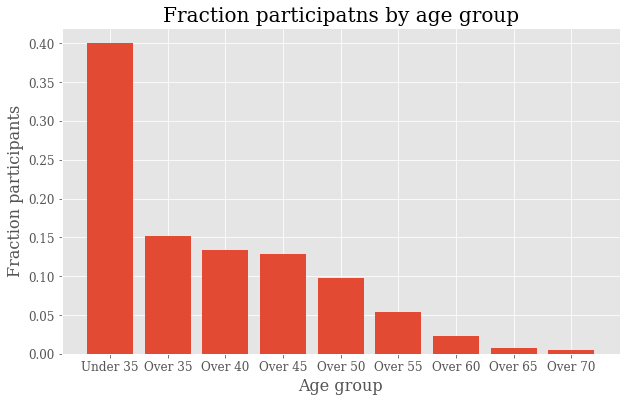

In [16]:
# bar plot that^

plt.figure(figsize=(10,6))

tmp = df.groupby('age').count()

tmp['rank'].sum()

x = ['Under 35', 'Over 35', 'Over 40', 'Over 45', 'Over 50', 'Over 55', 'Over 60', 'Over 65', 'Over 70']


y = [tmp.loc['Under 35', 'rank'], tmp.loc['Over 35 ', 'rank'], tmp.loc['Over 40 ', 'rank'],
     tmp.loc['Over 45 ', 'rank'], tmp.loc['Over 50 ', 'rank'], tmp.loc['Over 55 ', 'rank'],
     tmp.loc['Over 60 ', 'rank'], tmp.loc['Over 65 ', 'rank'], tmp.loc['Over 70 ', 'rank']
     ]
y = [item/tmp['rank'].sum() for item in y]

plt.bar(x, y)

plt.title('Fraction participatns by age group')
plt.ylabel('Fraction participants')
plt.xlabel('Age group')

plt.show()

In [17]:
df.groupby('gender').count()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,age
gender,,,,,,,,,
female,2541,2541,2541,2541,2537,2529,2497,2541,2541
male,4762,4762,4762,4762,4753,4740,4629,4762,4762


In [18]:
# hello this is me

df[df.number==5576]

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age
2720,3471,Martina Pugliese,5576,04:16:59,00:55:18,01:58:43,02:50:51,04:24:42,female,Under 35


In [19]:
# how are race numbers assigned?
df['number'].min()

102

In [20]:
df.groupby('total_time').count().sort_values('rank', ascending=False).head()

,rank,name,number,tenk_time,half_time,thirtyk_time,gun_time,gender,age
total_time,,,,,,,,,
03:40:20,7,7,7,7,7,7,7,7,7
03:55:49,5,5,5,5,5,4,5,5,5
04:14:53,5,5,5,5,5,4,5,5,5
04:40:16,5,5,5,5,5,5,5,5,5
04:59:19,5,5,5,5,5,5,5,5,5


## Mean times 

Add col for the total seconds - do each time separately. Drop nans when there are.

### total time

In [21]:
df['total_time_seconds'] = [item.hour*3600 + item.minute*60 + item.second for item in list(df['total_time'])]

In [22]:
df.head()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age,total_time_seconds
0,4651,Phillip Williams,3607,04:37:03,00:50:58,01:49:34,02:50:45,04:39:57,male,Over 35,16623
1,4652,Oliver Morrall,483,04:37:03,00:51:14,01:56:39,03:02:28,04:37:58,male,Under 35,16623
2,4653,Vicky Fairless,8911,04:37:03,00:58:35,02:04:22,03:00:49,04:46:05,female,Over 40,16623
3,4654,Martina Metzov?,12553,04:37:04,00:57:50,02:05:26,03:04:46,04:49:49,female,Over 45,16624
4,4655,Susanne B?cher,91095,04:37:04,01:04:02,02:12:49,03:08:22,04:54:01,male,Over 55,16624


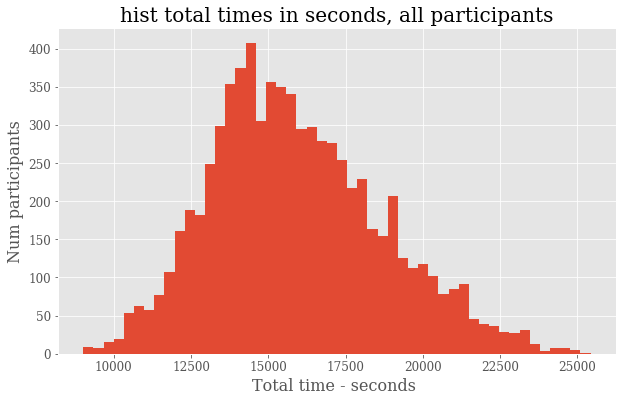

In [24]:
plt.figure(figsize=(10,6))

plt.hist(df['total_time_seconds'], bins=50)

plt.title('hist total times in seconds, all participants')
plt.ylabel('Num participants')
plt.xlabel('Total time - seconds ')

plt.show();

In [25]:
# stats about those^

df['total_time_seconds'].describe()

count     7303.000000
mean     15921.389018
std       2778.838389
min       9013.000000
25%      13922.500000
50%      15594.000000
75%      17698.500000
max      25431.000000
Name: total_time_seconds, dtype: float64

#### per gender

In [26]:
# this^ in seconds, write it in time format, choose the total_seconds to convert

total_seconds = 16707

'{h}:{m}:{s}'.format(h=int(total_seconds/3600), 
                     m=int((total_seconds/3600 - int(total_seconds/3600))*60),
                     s=round(((total_seconds/3600 - int(total_seconds/3600))*60 
                            - int((total_seconds/3600 - int(total_seconds/3600))*60))*60)
                    )

'4:38:27'

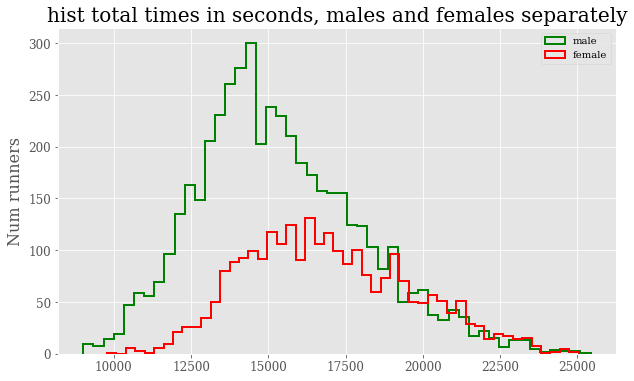

In [52]:
plt.figure(figsize=(10,6))

plt.hist(df[df.gender=='male']['total_time_seconds'], fill=False, edgecolor='g', lw=2,
         histtype='step', label='male', bins=50)
plt.hist(df[df.gender=='female']['total_time_seconds'], fill=False, edgecolor='r', 
         histtype='step', label='female', lw=2, bins=50)

plt.title('hist total times in seconds, males and females separately')
plt.ylabel('Num runners')
plt.legend()
plt.show();

In [53]:
# same, look at stats per gender

df[df.gender=='male']['total_time_seconds'].describe()

count     4762.000000
mean     15372.937631
std       2679.156243
min       9013.000000
25%      13531.000000
50%      15035.500000
75%      17065.250000
max      25431.000000
Name: total_time_seconds, dtype: float64

In [33]:
df[df.gender=='female']['total_time_seconds'].describe()

count     2541.000000
mean     16949.222747
std       2669.079601
min       9776.000000
25%      14965.000000
50%      16680.000000
75%      18868.000000
max      25048.000000
Name: total_time_seconds, dtype: float64

In [55]:
# this^ in seconds, write it in time format, choose the total_seconds to convert

total_seconds = 16949

'{h}:{m}:{s}'.format(h=int(total_seconds/3600), 
                     m=int((total_seconds/3600 - int(total_seconds/3600))*60),
                     s=round(((total_seconds/3600 - int(total_seconds/3600))*60 
                            - int((total_seconds/3600 - int(total_seconds/3600))*60))*60)
                    )

'4:42:29'

##### per age bracket (and gender)

In [35]:
f = df[(df.gender=='female')].groupby('age').agg({'total_time_seconds': ['count', 'mean', 'std']})
m = df[(df.gender=='male')].groupby('age').agg({'total_time_seconds': ['count', 'mean', 'std']})

m

total_time_seconds                           
                      count          mean          std
age                                                   
Over 35                 737  14981.230665  2644.809077
Over 40                 589  15132.039049  2745.418094
Over 45                 614  15324.311075  2573.605641
Over 50                 495  15556.789899  2571.512081
Over 55                 292  16087.099315  2513.350061
Over 60                 130  16342.400000  2567.327186
Over 65                  46  17493.195652  2717.009955
Over 70                  28  18339.000000  3444.637185
Under 35               1831  15293.352813  2667.804481

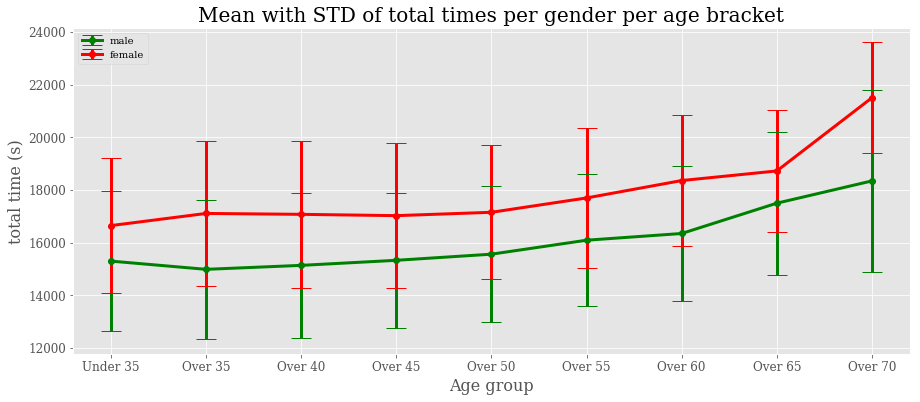

In [39]:
plt.figure(figsize=(15,6))

x = ['Under 35', 'Over 35', 'Over 40', 'Over 45', 'Over 50', 'Over 55', 'Over 60', 'Over 65', 'Over 70']

y_f = [f.loc['Under 35', ('total_time_seconds', 'mean')], 
       f.loc['Over 35 ', ('total_time_seconds', 'mean')], 
       f.loc['Over 40 ', ('total_time_seconds', 'mean')],
       f.loc['Over 45 ', ('total_time_seconds', 'mean')], 
       f.loc['Over 50 ', ('total_time_seconds', 'mean')], 
       f.loc['Over 55 ', ('total_time_seconds', 'mean')],
       f.loc['Over 60 ', ('total_time_seconds', 'mean')], 
       f.loc['Over 65 ', ('total_time_seconds', 'mean')], 
       f.loc['Over 70 ', ('total_time_seconds', 'mean')]
     ]
std_f = [f.loc['Under 35', ('total_time_seconds', 'std')], 
       f.loc['Over 35 ', ('total_time_seconds', 'std')], 
       f.loc['Over 40 ', ('total_time_seconds', 'std')],
       f.loc['Over 45 ', ('total_time_seconds', 'std')], 
       f.loc['Over 50 ', ('total_time_seconds', 'std')], 
       f.loc['Over 55 ', ('total_time_seconds', 'std')],
       f.loc['Over 60 ', ('total_time_seconds', 'std')], 
       f.loc['Over 65 ', ('total_time_seconds', 'std')], 
       f.loc['Over 70 ', ('total_time_seconds', 'std')]
     ]

y_m = [m.loc['Under 35', ('total_time_seconds', 'mean')], 
       m.loc['Over 35 ', ('total_time_seconds', 'mean')], 
       m.loc['Over 40 ', ('total_time_seconds', 'mean')],
       m.loc['Over 45 ', ('total_time_seconds', 'mean')], 
       m.loc['Over 50 ', ('total_time_seconds', 'mean')], 
       m.loc['Over 55 ', ('total_time_seconds', 'mean')],
       m.loc['Over 60 ', ('total_time_seconds', 'mean')], 
       m.loc['Over 65 ', ('total_time_seconds', 'mean')], 
       m.loc['Over 70 ', ('total_time_seconds', 'mean')]
     ]
std_m = [m.loc['Under 35', ('total_time_seconds', 'std')], 
       m.loc['Over 35 ', ('total_time_seconds', 'std')], 
       m.loc['Over 40 ', ('total_time_seconds', 'std')],
       m.loc['Over 45 ', ('total_time_seconds', 'std')], 
       m.loc['Over 50 ', ('total_time_seconds', 'std')], 
       m.loc['Over 55 ', ('total_time_seconds', 'std')],
       m.loc['Over 60 ', ('total_time_seconds', 'std')], 
       m.loc['Over 65 ', ('total_time_seconds', 'std')], 
       m.loc['Over 70 ', ('total_time_seconds', 'std')]
     ]

plt.errorbar(x, y_m, yerr=std_m, marker='o', label='male', capsize=10, c='g')
plt.errorbar(x, y_f, yerr=std_f, marker='o', label='female', capsize=10, c='r')

plt.title('Mean with STD of total times per gender per age bracket')
plt.legend()
plt.grid()
plt.ylabel('total time (s)')
plt.xlabel('Age group')

# if you want ticks in format h:m:s
ticks = ['{h}:{m}:{s}'.format(h=int(i/3600), 
                     m=int((i/3600 - int(i/3600))*60),
                     s=round(((i/3600 - int(i/3600))*60 
                            - int((i/3600 - int(i/3600))*60))*60)
                    ) for i in range(12000, 24000, 2000)]
#plt.yticks(range(12000, 26000, 2000), ticks)
plt.grid()
plt.show();

In [40]:
y_f

[16642.901924839596,
 17103.756032171583,
 17069.8671875,
 17020.415384615386,
 17147.541666666668,
 17692.24,
 18353.055555555555,
 18717.833333333332,
 21496.75]

In [41]:
# this^ in seconds, write it in time format, choose the total_seconds to convert

total_seconds = 12000

'{h}:{m}:{s}'.format(h=int(total_seconds/3600), 
                     m=int((total_seconds/3600 - int(total_seconds/3600))*60),
                     s=round(((total_seconds/3600 - int(total_seconds/3600))*60 
                            - int((total_seconds/3600 - int(total_seconds/3600))*60))*60)
                    )

'3:20:0'

## The slowdowns 
*  from 10k to half
* from half to 30k
* from 30k to end

In [42]:
# first add the times in seconds of the other times

df['tenk_time_seconds'] = [item.hour*3600 + item.minute*60 + item.second if item is not None else None
                           for item in list(df['tenk_time'])
                          ]
df['half_time_seconds'] = [item.hour*3600 + item.minute*60 + item.second if item is not None else None
                           for item in list(df['half_time'])]
df['thirtyk_time_seconds'] = [item.hour*3600 + item.minute*60 + item.second if item is not None else None
                              for item in list(df['thirtyk_time'])]

In [49]:
df.head()
df.sort_values('pace_total', ascending=True).head()

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age,...,tenk_time_seconds,half_time_seconds,thirtyk_time_seconds,pace_tenk,pace_half,pace_thirtyk,pace_total,pacediff_tenktohalf,pacediff_thirtyktohalf,pacediff_totaltothirtyk
2650,1,Dan Tanui,136,02:30:13,00:32:27,01:10:06,01:39:42,02:30:13,male,Under 35,...,1947.0,4206.0,5982.0,3.245000,3.338095,3.323333,3.560058,0.093095,-0.014762,0.236725
2651,2,Ollie Garrod,121,02:32:08,00:34:02,01:13:05,01:45:09,02:32:10,male,Under 35,...,2042.0,4385.0,6309.0,3.403333,3.480159,3.505000,3.605482,0.076825,0.024841,0.100482
2652,3,Tom Roche,127,02:32:19,00:33:56,01:12:32,01:44:30,02:32:19,male,Over 40,...,2036.0,4352.0,6270.0,3.393333,3.453968,3.483333,3.609827,0.060635,0.029365,0.126494
2653,4,Gedion Cheruiyot Kurgat,130,02:32:53,00:32:27,01:10:03,01:41:00,02:32:53,male,Under 35,...,1947.0,4203.0,6060.0,3.245000,3.335714,3.366667,3.623257,0.090714,0.030952,0.256590
2654,5,Matthew Richards,126,02:33:06,00:34:54,01:14:17,01:45:13,02:33:06,male,Under 35,...,2094.0,4457.0,6313.0,3.490000,3.537302,3.507222,3.628392,0.047302,-0.030079,0.121170


In [48]:
# calculate the paces at those distances (in min/km) as snapshots
# NOTE the paces are in minutes/km
# so this is a pace computed simply on the cumulative time and disntance to snapshot

df['pace_tenk'] = df['tenk_time_seconds']/60/10
df['pace_half'] = df['half_time_seconds']/60/21
df['pace_thirtyk'] = df['thirtyk_time_seconds']/60/30
df['pace_total'] = df['total_time_seconds']/60/42.195

In [45]:
# Compute slowdowns (or speedups!)

df['pacediff_tenktohalf'] = df['pace_half'] - df['pace_tenk']
df['pacediff_thirtyktohalf'] = df['pace_thirtyk'] - df['pace_half']
df['pacediff_totaltothirtyk'] = df['pace_total'] - df['pace_thirtyk']

In [47]:
# stats of the slowdowns/speedups
df.describe()[['pacediff_tenktohalf', 'pacediff_thirtyktohalf', 'pacediff_totaltothirtyk']]

,pacediff_tenktohalf,pacediff_thirtyktohalf,pacediff_totaltothirtyk
count,7264.000000,7111.000000,7126.000000
mean,0.136604,0.145078,0.347056
std,0.187372,0.181293,0.225952
min,-0.848254,-0.562460,-0.274372
25%,0.027381,0.018095,0.189185
50%,0.088968,0.093968,0.312918
75%,0.191131,0.226627,0.461941
max,2.712937,2.845317,3.952054


### Who's the heroes? 

I mean...this race is long. Hero: someone who increased their speed between the 30k mark and the end.

In [56]:
# how many people sped up between the 30k mark and the end?

df[df.pacediff_totaltothirtyk < 0].sort_values('pacediff_totaltothirtyk', ascending=True).head(10)

,rank,name,number,total_time,tenk_time,half_time,thirtyk_time,gun_time,gender,age,...,tenk_time_seconds,half_time_seconds,thirtyk_time_seconds,pace_tenk,pace_half,pace_thirtyk,pace_total,pacediff_tenktohalf,pacediff_thirtyktohalf,pacediff_totaltothirtyk
5459,3907,Mark Dickson,11919,04:24:03,01:07:49,02:19:55,03:15:58,04:39:14,male,Under 35,...,4069.0,8395.0,11758.0,6.781667,6.662698,6.532222,6.257850,-0.118968,-0.130476,-0.274372
1408,5959,Lucy Livingston,11739,05:06:18,01:14:35,02:38:12,03:44:07,05:08:37,female,Under 35,...,4475.0,9492.0,13447.0,7.458333,7.533333,7.470556,7.259154,0.075000,-0.062778,-0.211402
1407,5958,Punit Shah,1185,05:06:18,01:14:35,02:38:11,03:44:07,05:08:37,male,Under 35,...,4475.0,9491.0,13447.0,7.458333,7.532540,7.470556,7.259154,0.074206,-0.061984,-0.211402
3788,2639,Daniel Sanders,7074,04:03:28,01:00:55,02:06:42,02:59:20,04:11:39,male,Under 35,...,3655.0,7602.0,10760.0,6.091667,6.033333,5.977778,5.770036,-0.058333,-0.055556,-0.207742
2996,3297,Michael Holland,7668,04:14:24,00:57:55,02:09:13,03:05:12,04:23:33,male,Under 35,...,3475.0,7753.0,11112.0,5.791667,6.153175,6.173333,6.029150,0.361508,0.020159,-0.144183
5406,4754,Esther Wilson,13902,04:38:54,01:06:32,02:20:47,03:22:16,04:56:07,female,Over 40,...,3992.0,8447.0,12136.0,6.653333,6.703968,6.742222,6.609788,0.050635,0.038254,-0.132434
3421,1572,Kyle Hogg,8700,03:48:17,00:55:42,01:57:34,02:45:35,03:57:43,male,Under 35,...,3342.0,7054.0,9935.0,5.570000,5.598413,5.519444,5.410199,0.028413,-0.078968,-0.109246
2435,2286,Calum Baird,5700,03:58:35,00:55:19,01:57:47,02:52:52,04:08:10,male,Under 35,...,3319.0,7067.0,10372.0,5.531667,5.608730,5.762222,5.654303,0.077063,0.153492,-0.107919
4198,3396,Holly Mcleod,13873,04:15:51,01:03:41,02:12:14,03:05:07,04:31:59,female,Under 35,...,3821.0,7934.0,11107.0,6.368333,6.296825,6.170556,6.063515,-0.071508,-0.126270,-0.107041
3133,2434,Laura Buchan,9402,04:00:25,00:57:10,02:01:35,02:54:08,04:09:22,female,Over 40,...,3430.0,7295.0,10448.0,5.716667,5.789683,5.804444,5.697752,0.073016,0.014762,-0.106692


## Notes

* 7303 participants total
* 34.8% of which female
* I've checked by trying to sign up from scratch that you don't need to give the gender necessarily. however, all data points have a gender
* As for the age, you need to give it at signup time. The data shows age bucketing spaced by 5 years starting from "Over 35". Because you need to sign up with birthday necessarily, I assume all those without age in the data is because they are Under 35, so this has been imputed on the data
* note that for instance wording like "Over 35" means 35-39 as age bracket
* after doing this, 2922, or 40% of the participants are under 35, big drop to 15% being over 35, then more gentle drops
* just 32 participants are above 70 years old
* race numbers are assigned weirdly (?) - range from 102 (min) to 95386 (max); wonder if it has to do with people signing up on the website but never actually paying the quote to do the race, or also not showing up at the race?
* there's 5095 unique total times, so a fair amount of people shared their total time with someone else (crossed the finish line together with someone else) - note that the precision given by chips is at the second
* In particular, and this is the most people crossing together, 7 people crossed the finish at 3h40m20s, then 5 people together at 3h55m49s, and so on